<a href="https://colab.research.google.com/github/samriddhi1233/Assignment3_Webdev/blob/main/Bigdata_Individualassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Initialize Spark Session

In [ ]:
!pip install pyspark

In [ ]:
spark = SparkSession.builder.appName("HealthcareAnalytics").getOrCreate()

## Load Dataset

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, count, isnan, when, corr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, when, count
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import DataFrame

In [ ]:
df = spark.read.csv("/content/diabetes.csv", header=True, inferSchema=True)

numeric_columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                   "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

for col_name in numeric_columns:
    df = df.withColumn(col_name, F.col(col_name).cast(DoubleType()))

In [ ]:
def batch_processing(df: DataFrame) -> DataFrame:
    """
    Simulates batch processing by performing transformations on the dataset.
    """
    df = df.withColumn("BMI_Category", when(col("BMI") < 18.5, "Underweight")
                                     .when((col("BMI") >= 18.5) & (col("BMI") < 24.9), "Normal")
                                     .when((col("BMI") >= 25) & (col("BMI") < 29.9), "Overweight")
                                     .otherwise("Obese"))
    return df

df = batch_processing(df)
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|BMI_Category|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+------------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|    1.0|       Obese|
|        1.0|   85.0|         66.0|         29.0|    0.0|26.6|                   0.351|31.0|    0.0|  Overweight|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|    1.0|      Normal|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|    0.0|  Overweight|
|        0.0|  137.0|         40.0|         35.0|  168.0|43.1|                   2.288|33.0|    1.0|       Obese|
|        5.0|  116.0|         74.0|          0.0|    0.0|25.6|                   0.201|3

# **Data cleaning**





### **Handling missing value**

In [ ]:

columns_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for column in columns_to_check:
    df = df.withColumn(column, when(col(column) == 0, None).otherwise(col(column)))

df = df.dropna()

### **Removing Duplicates**

In [ ]:
df = df.dropDuplicates()

### **Correcting Inconsistencies**

In [ ]:
from pyspark.sql import functions as F

for column in df.columns:
    df = df.withColumn(column, F.trim(F.col(column)))


In [ ]:
# Recast to DoubleType after trimming to avoid reverting to string type
for column in df.columns:
    df = df.withColumn(column, F.trim(F.col(column)))
    if column in numeric_columns:  # Only recast numeric columns
        df = df.withColumn(column, F.col(column).cast(DoubleType()))

In [ ]:
# Validating Accuracy (Checking for out-of-range values)
df = df.filter((df.Age > 0) & (df.Age < 120))
df = df.filter((df.BloodPressure > 40) & (df.BloodPressure < 200))
df = df.filter((df.BMI > 10) & (df.BMI < 50))
df = df.filter((df.Glucose > 50) & (df.Glucose < 300))

# **Exploratory Data Analysis (EDA)**

In [ ]:
print("Summary Statistics:")
df.describe().show()

Summary Statistics:
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+-----------------+-------------------+------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|           Insulin|              BMI|DiabetesPedigreeFunction|              Age|            Outcome|BMI_Category|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+-----------------+-------------------+------------+
|  count|               382|               382|               382|               382|               382|              382|                     382|              382|                382|         382|
|   mean| 3.369109947643979| 122.4738219895288| 70.90052356020942|28.900523560209425|155.79842931937173|32.69162303664923|      0.5138638743455499|30.99214659685864|0.32722513089005234

### **Calculating Mean, Median, Mode, and Standard Deviation**

In [ ]:
statistics = df.select(
    F.mean("Age").alias("Mean Age"),
    F.expr("percentile(Age, 0.5)").alias("Median Age"),
    F.stddev("Age").alias("StdDev Age")
)
statistics.show()

+-----------------+----------+-----------------+
|         Mean Age|Median Age|       StdDev Age|
+-----------------+----------+-----------------+
|30.99214659685864|      27.0|10.28376602582882|
+-----------------+----------+-----------------+



### **Count missing values per column**

In [ ]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|BMI_Category|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+------------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|           0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+------------+



### **Correlation Matrix**

In [ ]:
corr_matrix = df.select([F.corr("Age", c).alias(c) for c in df.columns if c != "Age"])
corr_matrix.show()

+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------------+-------------------+------------+
|       Pregnancies|            Glucose|     BloodPressure|      SkinThickness|            Insulin|                BMI|DiabetesPedigreeFunction|            Outcome|BMI_Category|
+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------------+-------------------+------------+
|0.6800803921145406|0.35314856348445256|0.3309645205381841|0.18428382163322632|0.22933931260286866|0.11070202860485713|     0.10150780683675904|0.36016123192204846|        NULL|
+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------------+-------------------+------------+



# **Visualization**

In [ ]:
df_pd = df.toPandas()

In [ ]:
print("Summary Statistics:")
print(df_pd.describe())

Summary Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   382.000000  382.000000     382.000000     382.000000  382.000000   
mean      3.369110  122.473822      70.900524      28.900524  155.798429   
std       3.221872   30.849275      11.533157      10.311961  116.707089   
min       0.000000   56.000000      44.000000       7.000000   15.000000   
25%       1.000000   99.000000      62.000000      21.000000   76.250000   
50%       2.000000  119.000000      70.000000      29.000000  126.000000   
75%       5.000000  143.000000      78.000000      36.000000  190.000000   
max      17.000000  198.000000     110.000000      60.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  382.000000                382.000000  382.000000  382.000000  
mean    32.691623                  0.513864   30.992147    0.327225  
std      6.322346                  0.322229   10.283766    0.469816  
min     18.2000

## **Histograms**

<Figure size 1200x600 with 0 Axes>

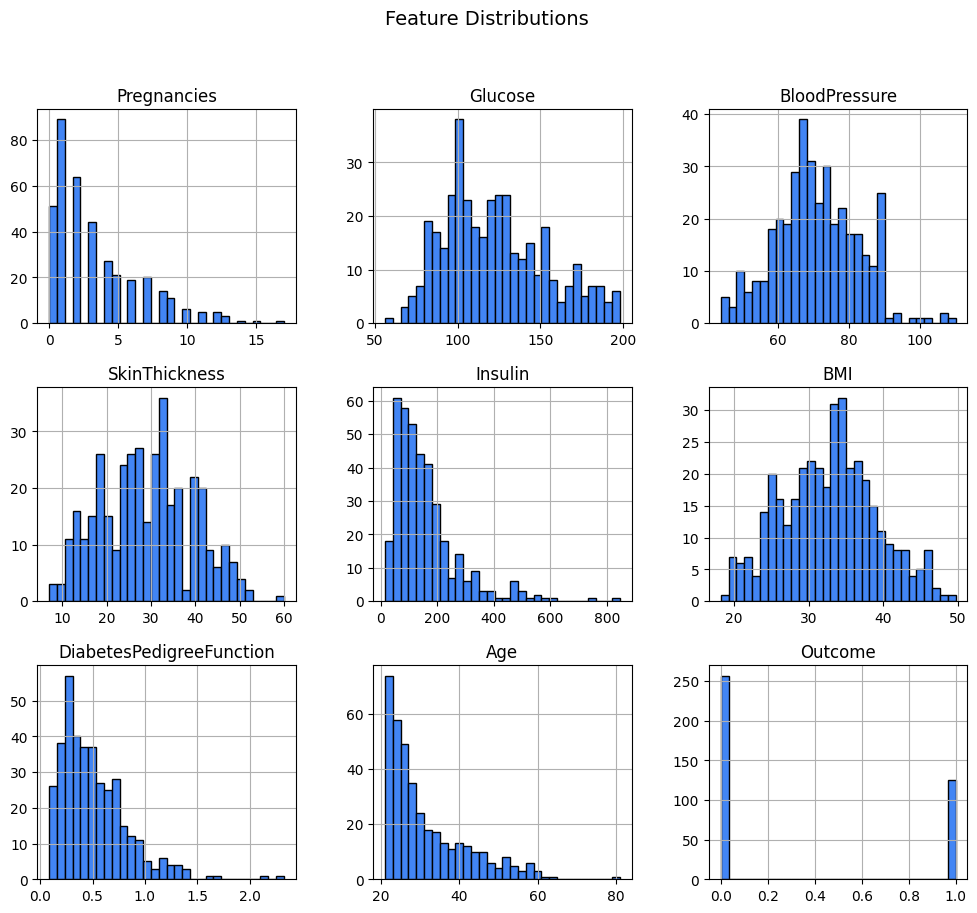

In [ ]:
numeric_cols = df_pd.select_dtypes(include=['number']).columns

plt.figure(figsize=(12, 6))
df_pd[numeric_cols].hist(figsize=(12, 10), bins=30, color='#4285F4', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


## **Correlation Heatmap**

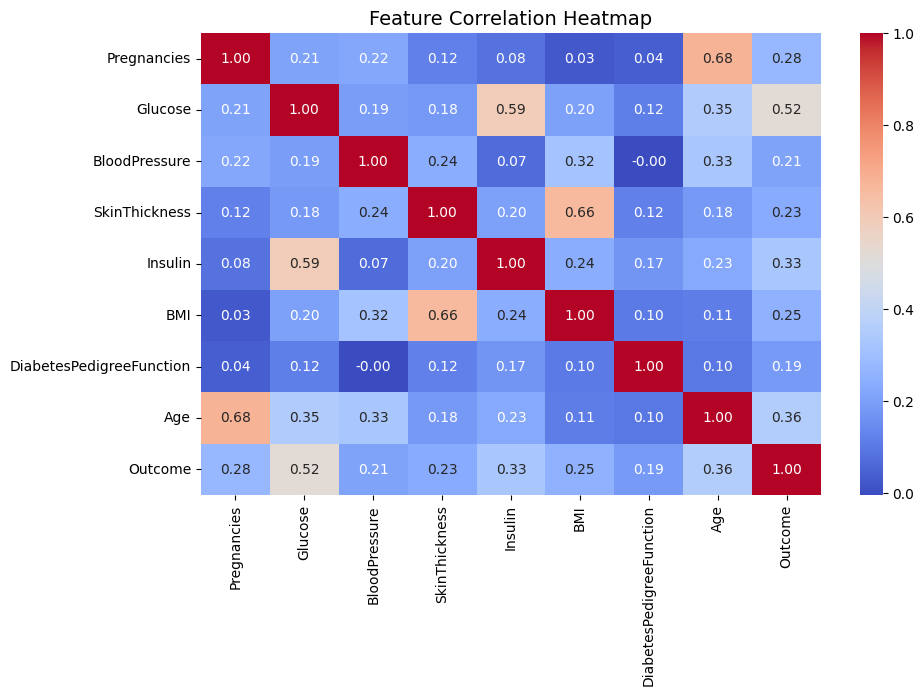

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_pd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

## **Boxplot for Outlier Detection**

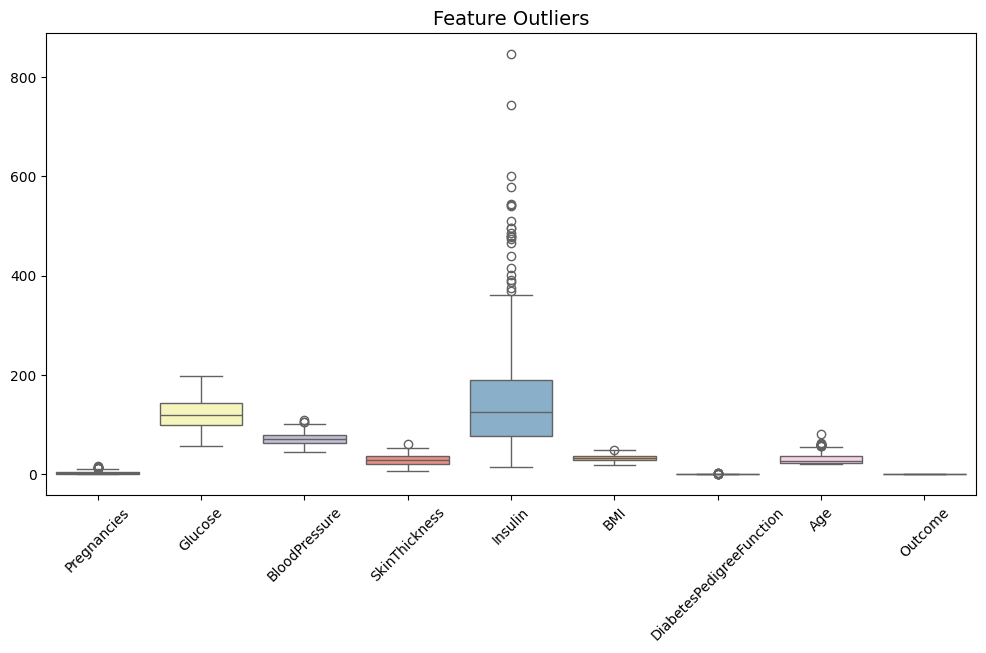

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pd, palette="Set3")
plt.title("Feature Outliers", fontsize=14)
plt.xticks(rotation=45)
plt.show()

## **Pairplot for Relationship Between Features**

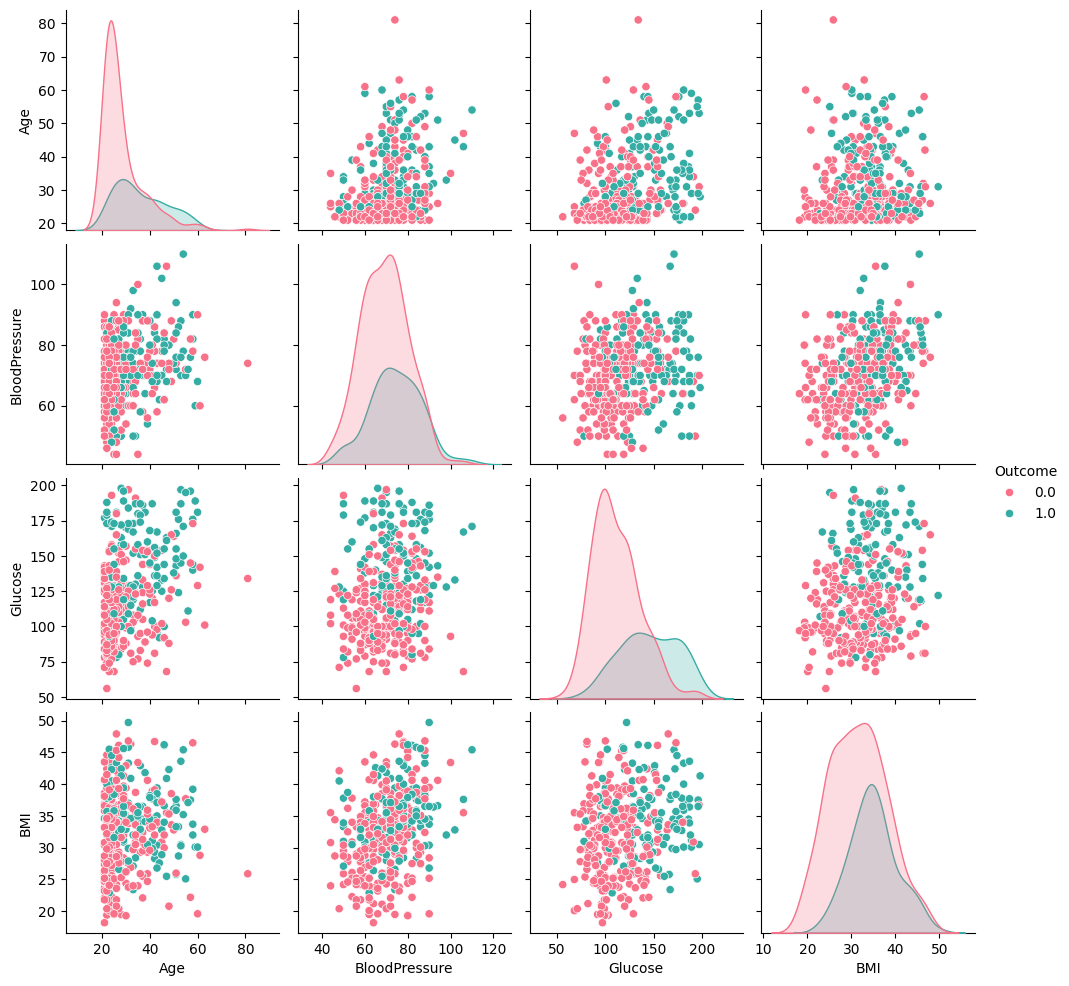

In [ ]:
sns.pairplot(df_pd[['Age', 'BloodPressure', 'Glucose', 'BMI', 'Outcome']], hue="Outcome", palette="husl")
plt.show()

## **Outcome Distribution (Bar Plot)**

<ipython-input-26-be927f2b34d8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_pd['Outcome'], palette=["#FFA07A", "#20B2AA"])


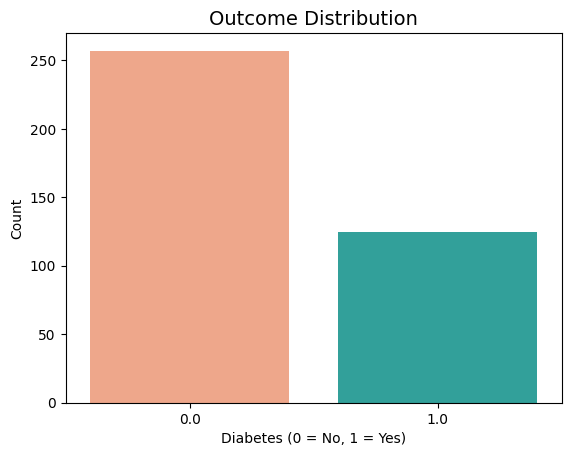

In [ ]:
sns.countplot(x=df_pd['Outcome'], palette=["#FFA07A", "#20B2AA"])
plt.title("Outcome Distribution", fontsize=14)
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# **Feature Engineering**

In [ ]:
assembler = VectorAssembler(inputCols=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"], outputCol="features")
data = assembler.transform(df)

### **Splitting Data into Train & Test**

In [ ]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

### **Logistic Regression Model**

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='Outcome')
model = lr.fit(train)

## **Model Predictions**

In [ ]:
predictions = model.transform(test)

# **Model Evaluation - Accuracy,Precision, Recall, and F1 Score Calculation**

In [ ]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

TP = predictions.filter((col("Outcome") == 1) & (col("prediction") == 1)).count()
FP = predictions.filter((col("Outcome") == 0) & (col("prediction") == 1)).count()
FN = predictions.filter((col("Outcome") == 1) & (col("prediction") == 0)).count()
TN = predictions.filter((col("Outcome") == 0) & (col("prediction") == 0)).count()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.7679
Precision: 0.6429
Recall: 0.5294
F1 Score: 0.5806


In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='Outcome')
lr_model = lr.fit(train)
predictions_lr = lr_model.transform(test)

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Outcome', numTrees=100)
rf_model = rf.fit(train)
predictions_rf = rf_model.transform(test)

In [ ]:
# Gradient Boosting Tree Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='Outcome', maxIter=10)
gbt_model = gbt.fit(train)
predictions_gbt = gbt_model.transform(test)

In [ ]:
# Naive Bayes Classifier
nb = NaiveBayes(featuresCol='features', labelCol='Outcome')
nb_model = nb.fit(train)
predictions_nb = nb_model.transform(test)

In [ ]:
# K-Means Clustering (for Patient Segmentation)
kmeans = KMeans(featuresCol='features', k=2, seed=42)
kmeans_model = kmeans.fit(data)
kmeans_predictions = kmeans_model.transform(data)

In [ ]:
# Model Evaluation
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")

accuracy_lr = accuracy_evaluator.evaluate(predictions_lr)
accuracy_rf = accuracy_evaluator.evaluate(predictions_rf)

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Logistic Regression Accuracy: 0.7679
Random Forest Accuracy: 0.6964


NameError: name 'kmeans_pd' is not defined

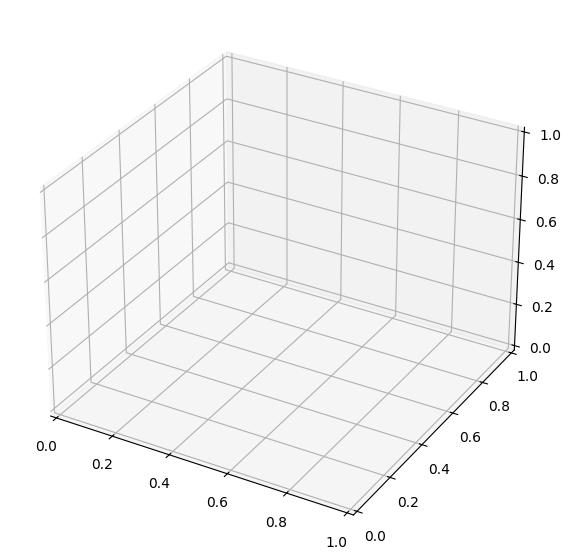